In [1]:
from smartem import smartem,tools
from smartem.online import microscope,get_rescan_maps
from smartem.offline.train_mb_error_detector.NNtools import UNet as UNet_offline
from smartem.offline.train_mb_error_detector.tools import get_error_GT
from smartem.online.models import UNet as UNet_online
from smartem.segmentation import segmenter, utils
import h5py
import numpy as np
from skimage import io, measure
from pathlib import Path
import matplotlib.pyplot as plt
import pyvoi
import seaborn as sns
import pandas as pd
from tqdm import tqdm 
import torch
import os
import scipy.ndimage as ndi

In [11]:
hdf5_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
temp_dir = "/storage2/projects/smartEM/em-vis/temp/"

device = torch.device("cuda:1")

em2mb_model_us = UNet_offline.UNet(1,2)
em2mb_model_core = UNet_online.UNet(1,2)
em2mb_path_us = "../../pretrained_models/em2mb_best.pth"
errnet_path_us = "../../pretrained_models/error_best.pth"
em2mb_path_core = "../../pretrained_models_core/em2mb_best.pth"
errnet_path_core = "../../pretrained_models_core/error_best.pth"

fast_dwt = 50
slow_dwt = 800
rescan_ratios = [0, 0.05, 0.1, 0.25, 0.5, 1.0]
valid_dwts = [25, 50, 75, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200]

In [3]:
Iseg_us = segmenter.Segmenter(em2mb_path_us, segmenter_function = measure.label, device=device)
Iseg_us.set_model(model_class=em2mb_model_us)

Iseg_core = segmenter.Segmenter(em2mb_path_core, segmenter_function = measure.label, device=device)
Iseg_core.set_model(model_class=em2mb_model_core)

Not using custom watershed function - will invert images before segmenting...
Not using custom watershed function - will invert images before segmenting...


## Rescan oracle

In [21]:
data_hdt_vois = []
data_re_ratio = []
data_methods = []
data_rescan = []

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions...", disable=False):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - gt_mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # get hdt labels
        slowest_em = group[f"{slowest_dwt}/im"][()]

        hdt_membrane_mask_us, hdt_mb_probs_us = Iseg_us.get_membranes(slowest_em, get_probs=True)
        hdt_mb_probs_us = (hdt_mb_probs_us*255).astype(np.uint8)
        hdt_labels_us = Iseg_us.get_labels(slowest_em)
        hdt_labels_core = Iseg_core.get_labels(slowest_em)
        hdt_membrane_mask_core, hdt_mb_probs_core = Iseg_core.get_membranes(slowest_em, get_probs=True)
        hdt_mb_probs_core = (hdt_mb_probs_core*255).astype(np.uint8)

        # acquire
        fast_em = group[f"{fast_dwt}/im"][()]
        slow_em = group[f"{slow_dwt}/im"][()]

        # Rescan
        fdt_labels_us = Iseg_us.get_labels(fast_em)
        mb_mask, mb_probs = Iseg_us.get_membranes(fast_em, get_probs=True)
        mb_probs = (mb_probs*255).astype(np.uint8)
        rescan_map = get_error_GT(mb_probs, hdt_mb_probs_us)
        #rescan_map = np.pad(rescan_map, ((4,4),(0,0)))

        # merged_em = fast_em.copy()
        # merged_em[rescan_map] = slowest_em[rescan_map]
        # print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
        #labels_us = Iseg_us.get_labels(merged_em)
        mb_mask[rescan_map] = hdt_membrane_mask_us[rescan_map]
        labels_us = measure.label(255-mb_mask)

        fdt_labels_core = Iseg_core.get_labels(fast_em)
        mb_mask, mb_probs = Iseg_core.get_membranes(fast_em, get_probs=True)
        mb_probs = (mb_probs*255).astype(np.uint8)
        rescan_map = get_error_GT(mb_probs, hdt_mb_probs_core)
        #rescan_map = np.pad(rescan_map, ((4,4),(0,0)))

        # merged_em = fast_em.copy()
        # merged_em[rescan_map] = slowest_em[rescan_map]
        # print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
        #labels_core = Iseg_core.get_labels(merged_em)
        mb_mask[rescan_map] = hdt_membrane_mask_core[rescan_map]
        labels_core = measure.label(255-mb_mask)
    
        # Compute VI
        voi_gt_us,_,_ = -1, 0, 0 #pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
        voi_hdt_us,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
        voi_hdt_us = voi_hdt_us.item()
        voi_gt_core,_,_ = -1, 0, 0 # pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
        voi_hdt_core,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
        voi_hdt_core = voi_hdt_core.item()

        voi,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
        voi = voi.item()
        data_hdt_vois.append(voi)
        data_methods.append(f"Trained @ MIT: {fast_dwt}/{slow_dwt}ns")
        data_rescan.append("Rescan")

        voi,_,_ = pyvoi.VI(hdt_labels_us.flatten(), fdt_labels_us.flatten())
        voi = voi.item()
        data_hdt_vois.append(voi)
        data_methods.append(f"Trained @ MIT: {fast_dwt}/{slow_dwt}ns")
        data_rescan.append("No rescan")

        voi,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
        voi = voi.item()
        data_hdt_vois.append(voi)
        data_methods.append(f"Trained by Core: {fast_dwt}/{slow_dwt}ns")
        data_rescan.append("Replacement")

        voi,_,_ = pyvoi.VI(hdt_labels_core.flatten(), fdt_labels_core.flatten())
        voi = voi.item()
        data_hdt_vois.append(voi)
        data_methods.append(f"Trained by Core: {fast_dwt}/{slow_dwt}ns")
        data_rescan.append("No replacement")

data = {"Method": data_methods, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois, "Rescan Status": data_rescan}
df = pd.DataFrame(data=data)

segmenting regions...: 100%|██████████| 18/18 [10:22<00:00, 34.58s/it]


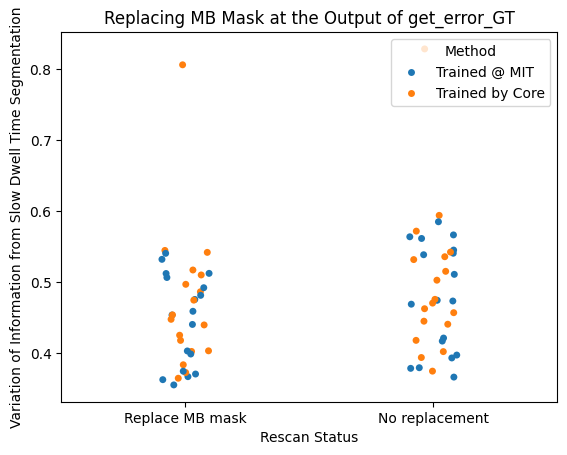

In [38]:
plot = sns.stripplot(data=df, y="Variation of Information from Slow Dwell Time Segmentation", x="Rescan Status", hue="Method")
plot.set(title='Replacing MB Mask at the Output of get_error_GT')
sns.move_legend(plot, "upper right")

### Vary rescan ratio

In [71]:
data_hdt_vois = []
data_gt_vois = []
data_re_ratio = []
data_methods = []

with h5py.File(hdf5_path, 'r') as f:
    for rescan_ratio in tqdm(rescan_ratios[1:3], desc="varying rescan ratios..."):
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
            #print(f"{gt_mask.shape}, {gt_mask.dtype} {np.amin(gt_mask)}-{np.amax(gt_mask)}")

            # get hdt labels
            slowest_em = group[f"{slowest_dwt}/im"][()]
            hdt_labels_us = Iseg_us.get_labels(slowest_em)
            hdt_labels_core = Iseg_core.get_labels(slowest_em)

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]
                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                if not os.path.isfile(im_file_path):
                    io.imsave(im_file_path, im)

                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)

            # make smartem object
            params = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_us.initialize(unet_version="offline")

            params = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_core.initialize(unet_version="online")

            # acquire
            fast_em = group[f"{fast_dwt}/im"][()]
            slow_em = group[f"{slow_dwt}/im"][()]
            # uncertainty
            _, mb_probs = Iseg_us.get_membranes(fast_em, get_probs=True)
            mb_certainty = np.abs(0.5 - mb_probs)
            percentile = np.percentile(mb_certainty.flatten(), rescan_ratio * 100)
            rescan_map = mb_certainty < percentile #/ 10
            # for i in range(5):
            #     rescan_map_temp = ndi.binary_dilation(rescan_map)
            #     if (np.sum(rescan_map_temp) / rescan_map.size) <= rescan_ratio:
            #         print("dilating...")
            #         rescan_map = rescan_map_temp
            #     else:
            #         break

            # indices = np.where(rescan_map == False)
            # sorted_indices = sorted((tpl for tpl in zip(*indices)), 
            #                         key=lambda x: mb_certainty[x[0], x[1]])

            # diff = rescan_ratio * rescan_map.size - np.sum(rescan_map)
            # diff = int(diff)
            # for idx in sorted_indices[:diff]:
            #     rescan_map[idx[0], idx[1]] = True


            assert (np.sum(rescan_map) / rescan_map.size) <= rescan_ratio
            rescan_map = np.pad(rescan_map, ((4,4), (0,0)))

            # random
            # rescan_map_coords = np.random.randint(0, fast_em.shape, size=(int(rescan_ratio*fast_em.size),2))
            # rescan_map = np.zeros(fast_em.shape, dtype='bool')
            # for coord in rescan_map_coords:
            #     rescan_map[coord[0], coord[1]] = True

            # errnet
            # params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            # fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)

            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
            labels_us = Iseg_us.get_labels(merged_em)

            # acquire
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_core.acquire(params=params)
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
            labels_core = Iseg_core.get_labels(merged_em)
        
            # Compute VI
            voi_gt_us,_,_ = -1, 0, 0 #pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            voi_hdt_us,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            voi_hdt_us = voi_hdt_us.item()
            voi_gt_core,_,_ = -1, 0, 0 # pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            voi_hdt_core,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            voi_hdt_core = voi_hdt_core.item()

            data_gt_vois.append(voi_gt_us)
            data_hdt_vois.append(voi_hdt_us)
            data_re_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM trained @ MIT: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_core)
            data_hdt_vois.append(voi_hdt_core)
            data_re_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM Networks from Core: {fast_dwt}/{slow_dwt}ns")


data = {"Method": data_methods, "Variation of Information from GT": data_gt_vois, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois, "Rescan Ratio": data_re_ratio}
df = pd.DataFrame(data=data)

varying rescan ratios...:   0%|          | 0/2 [00:00<?, ?it/s]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
0.04975609756097561: 0.05920985772357724
Inverting the image as not using custom watershed function


/home/tommy-local/projects/smartem/SmartEM/smartem/online/get_rescan_maps.py:156: UserWarning: This is very slow in the current implementation.
  warnings.warn("This is very slow in the current implementation.")


0.05: 0.059367378048780485
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
0.04975609756097561: 0.05904471544715447
Inverting the image as not using custom watershed function
0.05: 0.059314977134146345
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
0.04975609756097561: 0.05861852134146341
Inverting the image as not using custom watershed function
0.05: 0.0588598831300813
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
0.04975609756097561: 0.05945439532520325
Inverting the image as not using custom watershed function
0.05: 0.05964621443089431
Inverting the image as not using custom watershed function
Inver

varying rescan ratios...:  50%|█████     | 1/2 [01:19<01:19, 79.97s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
0.09951219512195122: 0.10850133384146342
Inverting the image as not using custom watershed function
0.1: 0.10890688516260162
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
0.09951219512195122: 0.10838192327235772
Inverting the image as not using custom watershed function
0.1: 0.10889608739837399
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
0.09951219512195122: 0.10793572154471545
Inverting the image as not using custom watershed function
0.1: 0.10843908790650407
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using cu

varying rescan ratios...: 100%|██████████| 2/2 [02:39<00:00, 79.51s/it]


[Text(0.5, 1.0, 'SmartEM on Test (Held out) Data with 50/800ns')]

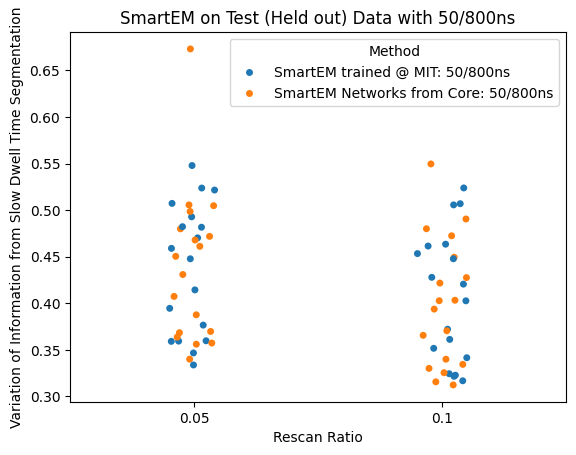

In [72]:
plot = sns.stripplot(data=df, y="Variation of Information from Slow Dwell Time Segmentation", x="Rescan Ratio", hue="Method")
plot.set(title='SmartEM on Test (Held out) Data with 50/800ns')

### Effective dwell time

In [21]:
data_hdt_vois = []
data_gt_vois = []
data_imaging_time = []
data_method = []

with h5py.File(hdf5_path, 'r') as f:
    for eff_dwt in tqdm(valid_dwts, desc="varying rescan ratios..."):
        if eff_dwt < fast_dwt or eff_dwt > slow_dwt:
            continue
        # base + rescan_ratio*slow = eff
        rescan_ratio = (eff_dwt - fast_dwt)/slow_dwt
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
            #print(f"{gt_mask.shape}, {gt_mask.dtype} {np.amin(gt_mask)}-{np.amax(gt_mask)}")

            im = group[f"{slowest_dwt}/im"][()]
            hdt_labels_us = Iseg_us.get_labels(im)
            hdt_labels_core = Iseg_core.get_labels(im)

            im = group[f"{eff_dwt}/im"][()]
            single_dwt_labels_us = Iseg_us.get_labels(im)
            single_dwt_labels_core = Iseg_core.get_labels(im)

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]

                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                io.imsave(im_file_path, im)
                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)


            params = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map_us = get_rescan_maps.GetRescanMapMembraneErrors(params=params)
            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map_us
            )
            my_smart_em_us.initialize(unet_version="offline")

            params = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map_core = get_rescan_maps.GetRescanMapMembraneErrors(params=params)
            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map_core
            )
            my_smart_em_core.initialize(unet_version="online")
            
            # Acquire
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            labels_us = Iseg_us.get_labels(merged_em)

            fast_em, slow_em, rescan_map, *_ = my_smart_em_core.acquire(params=params)
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            labels_core = Iseg_core.get_labels(merged_em)
        

            data_method.append(f"Our SmartEM {fast_dwt}/{slow_dwt}")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_imaging_time.append(eff_dwt * im.size/1e9)


            data_method.append(f"Our Single Dwell Time EM2MB")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), single_dwt_labels_us.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_us.flatten(), single_dwt_labels_us.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_imaging_time.append(eff_dwt * im.size/1e9)


            data_method.append(f"Core SmartEM {fast_dwt}/{slow_dwt}")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_imaging_time.append(eff_dwt * im.size/1e9)


            data_method.append(f"Core Single Dwell Time EM2MB")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), single_dwt_labels_core.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_core.flatten(), single_dwt_labels_core.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_imaging_time.append(eff_dwt * im.size/1e9)


data = {f"Total Imaging Time per {im.shape} Image (s)": data_imaging_time, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois, "Method": data_method}
df = pd.DataFrame(data=data)

varying rescan ratios...:   0%|          | 0/14 [00:00<?, ?it/s]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function


/home/tommy-local/projects/smartem/SmartEM/smartem/online/get_rescan_maps.py:156: UserWarning: This is very slow in the current implementation.
  warnings.warn("This is very slow in the current implementation.")


Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  14%|█▍        | 2/14 [02:38<15:51, 79.30s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  21%|██▏       | 3/14 [05:18<20:42, 112.91s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  29%|██▊       | 4/14 [07:57<21:40, 130.05s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  36%|███▌      | 5/14 [10:35<20:58, 139.84s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  43%|████▎     | 6/14 [13:14<19:29, 146.13s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  50%|█████     | 7/14 [15:52<17:29, 149.97s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  57%|█████▋    | 8/14 [18:31<15:16, 152.69s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  64%|██████▍   | 9/14 [21:10<12:53, 154.78s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  71%|███████▏  | 10/14 [23:49<10:24, 156.11s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  79%|███████▊  | 11/14 [26:28<07:50, 156.86s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...: 100%|██████████| 14/14 [29:06<00:00, 124.76s/it]


In [45]:
df

,"Total Imaging Time per (1640, 1920) Image (s)",Variation of Information from GT (nats),Variation of Information from 1200ns (nats),Method,Dwell Time (ns)
0,0.16,0.500557,0.379059,Our SmartEM 50/800,51.0
1,0.16,0.500557,0.379059,Our Single Dwell Time EM2MB,51.0
2,0.16,0.547945,0.440403,Core SmartEM 50/800,51.0
3,0.16,0.547945,0.440403,Core Single Dwell Time EM2MB,51.0
4,0.16,0.602743,0.473148,Our SmartEM 50/800,51.0
...,...,...,...,...,...
787,2.52,0.452293,0.171486,Core Single Dwell Time EM2MB,800.0
788,2.52,0.461274,0.159648,Our SmartEM 50/800,800.0
789,2.52,0.459478,0.157456,Our Single Dwell Time EM2MB,800.0
790,2.52,0.412583,0.176342,Core SmartEM 50/800,800.0


In [51]:
df["Total Imaging Time per (1640, 1920) Image (s)"].unique()


array([0.16, 0.24, 0.31, 0.39, 0.47, 0.63, 0.94, 1.26, 1.57, 1.89, 2.52])

In [53]:
df["Effective Dwell Time (ns)"] = edts

In [54]:
df

,"Total Imaging Time per (1640, 1920) Image (s)",Variation of Information from GT (nats),Variation of Information from 1200ns (nats),Method,Effective Dwell Time (ns)
0,0.16,0.500557,0.379059,Our SmartEM 50/800,50
1,0.16,0.500557,0.379059,Our Single Dwell Time EM2MB,50
2,0.16,0.547945,0.440403,Core SmartEM 50/800,50
3,0.16,0.547945,0.440403,Core Single Dwell Time EM2MB,50
4,0.16,0.602743,0.473148,Our SmartEM 50/800,50
...,...,...,...,...,...
787,2.52,0.452293,0.171486,Core Single Dwell Time EM2MB,800
788,2.52,0.461274,0.159648,Our SmartEM 50/800,800
789,2.52,0.459478,0.157456,Our Single Dwell Time EM2MB,800
790,2.52,0.412583,0.176342,Core SmartEM 50/800,800


In [52]:
edts = []
t2dt = {0.16: 50, 0.24: 75, 0.31:100, 0.39:125, 0.47:150, 0.63:200, 0.94:300, 1.26:400, 1.57:500, 1.89:600, 2.52:800 }
for i, row in df.iterrows():
    edts.append(t2dt[row["Total Imaging Time per (1640, 1920) Image (s)"]])
edts

[50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100

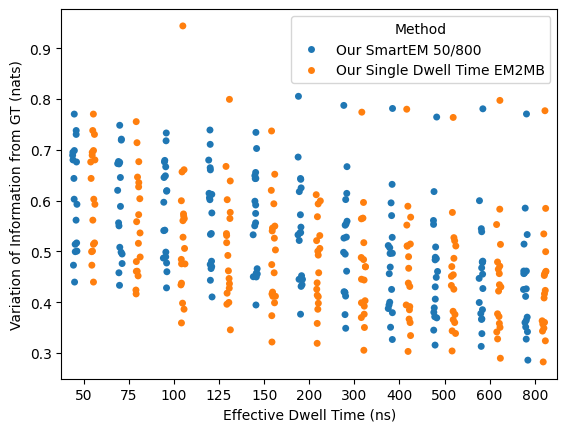

In [55]:
plot = sns.stripplot(data=df[df["Method"].isin(["Our Single Dwell Time EM2MB", "Our SmartEM 50/800"])], y="Variation of Information from GT (nats)", x=f"Effective Dwell Time (ns)", hue="Method", dodge=True)
# plot.set(title='SmartEM on Test (Held out) Data with 50/800ns Dwell Time')

In [23]:
imaging_time = []
for idx, row in df.iterrows():
    dwt = row["Effective Dwell Time (ns)"]
    imaging_time.append(dwt * im.size/1e9)

In [28]:
imaging_time

[0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.15744,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.23616,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,
 0.31488,


In [29]:
df["Total Imaging Time (s)"] = df["Total Imaging Time (s)"].round(2)

In [30]:
df

,Effective Dwell Time (ns),Variation of Information from GT (nats),Variation of Information from 1200ns (nats),Method,Total Imaging Time (s)
0,50,0.500557,0.379059,SmartEM 50/800,0.16
1,50,0.500557,0.379059,Single Dwell Time,0.16
2,50,0.602743,0.473148,SmartEM 50/800,0.16
3,50,0.602743,0.473148,Single Dwell Time,0.16
4,50,0.513964,0.416633,SmartEM 50/800,0.16
...,...,...,...,...,...
391,800,0.499377,0.222407,Single Dwell Time,2.52
392,800,0.457220,0.169042,SmartEM 50/800,2.52
393,800,0.455649,0.165570,Single Dwell Time,2.52
394,800,0.461274,0.159648,SmartEM 50/800,2.52


## Visualize

In [ ]:
images = {}

with h5py.File(hdf5_path, 'r') as f:
    reg = list(f.keys())[2]

    group = f[reg]
    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]

    gt_mask = group[f"{slowest_dwt}/mask"][()]
    gt_labels = measure.label(255 - gt_mask)

    if gt_labels.shape[0] % 32 != 0:
        gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
    gt_labels_shuffled = utils.shuffle_labels(gt_labels)
    gt_labels_masked = np.ma.masked_where(gt_labels_shuffled == 0, gt_labels_shuffled)

    gt_im = group[f"{slowest_dwt}/im"][()]
    hdt_labels = Iseg.get_labels(im)

    image_names = {}

    for dwt in dwts:
        im = group[f"{dwt}/im"][()]

        im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
        io.imsave(im_file_path, im)
        image_names[dwt] = str(im_file_path)

    params = {"images_ns": image_names}
    my_microscope = microscope.FakeDataMicroscope(params=params)

    for rescan_ratio in tqdm(rescan_ratios, desc="varying rescan ratios..."):
        params = {
            "em2mb_net": em2mb_path,
            "error_net": "../../pretrained_models/error_best.pth",
            "device": device,
            "pad": 0,
            "rescan_p_thres": None, # 0.1
            "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
            "search_step": 0.01,
            #"do_clahe": False,
        }
        get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

        my_smart_em = smartem.SmartEM(
            microscope=my_microscope, get_rescan_map=get_rescan_map
        )

        my_smart_em.initialize()
        
        params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
        fast_em, slow_em, rescan_map, *_ = my_smart_em.acquire(params=params)
        merged_em = fast_em.copy()
        merged_em[rescan_map] = slow_em[rescan_map]

        _, mb_probs = Iseg.get_membranes(merged_em, get_probs=True)
        labels = Iseg.get_labels(merged_em)

        labels_shuffled = utils.shuffle_labels(labels)
        labels_masked = np.ma.masked_where(labels_shuffled == 0, labels_shuffled)

        voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
    
        title_stem = f"rescan_ratio_{rescan_ratio}_VOI_{voi_gt.item():.2f}"

        images[title_stem + "_image"] = merged_em
        images[title_stem + "_label"] = labels_masked
        images[title_stem + "_pred"] = mb_probs


images["ground_truth_image"] = gt_im
images["ground_truth_label"] = gt_labels_masked
images["ground_truth_pred"] = gt_mask
images["high_dwell_time_image"] = gt_im


In [ ]:
utils.visualize(**images)